In [64]:
import numpy as np
from dataclasses import dataclass
from typing import Tuple, Dict, Any, Optional, Callable, List

import torch
import torch.nn as nn
from torch.distributions import Categorical

import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)


In [65]:
@dataclass
class GridEnvConfig:
    width: int = 5
    height: int = 5
    # When no function is provided, we fallback to a constant reward
    stop_reward: float = 1.0
    stop_reward_fn: Optional[Callable[[int, int], float]] = None


class GridEnv:
    """
    Simple grid where agent starts at (0, 0) and can move right, up, or stop.
    - State: (x, y)
    - Actions: 0=right, 1=up, 2=stop
    - When stop is chosen, episode ends and reward is either constant or from a callable.
    - Moving yields zero reward; out-of-bounds moves are clipped at the border.
    """

    def __init__(self, config: GridEnvConfig = GridEnvConfig()):
        self.config = config
        self.action_meanings = {0: "right", 1: "up", 2: "stop"}
        self.reset()

    def reset(self) -> Tuple[np.ndarray, Dict[str, Any]]:
        self.x = 0
        self.y = 0
        obs = np.array([self.x, self.y], dtype=np.float32)
        info: Dict[str, Any] = {}
        return obs, info

    # This implementation is far from optimal, but it is simple and it works.
    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, Dict[str, Any]]:
        assert action in (0, 1, 2), "Invalid action"
        terminated = False
        truncated = False
        reward = 0.0

        if action == 0:  # right
            self.x = min(self.x + 1, self.config.width - 1)
        elif action == 1:  # up
            self.y = min(self.y + 1, self.config.height - 1)
        else:  # stop
            terminated = True
            reward = self.get_reward()

        obs = np.array([self.x, self.y], dtype=np.float32)
        info: Dict[str, Any] = {}
        return obs, reward, terminated, truncated, info

    def get_reward(self) -> float:
        if self.config.stop_reward_fn is not None:
            return float(self.config.stop_reward_fn(self.x, self.y))
        else:
            return float(self.config.stop_reward)

    def render(self) -> None:
        grid = np.full((self.config.height, self.config.width), fill_value=".")
        grid[self.config.height - 1 - self.y, self.x] = "A"
        print("\n".join("".join(row) for row in grid))


In [66]:
class MLPPolicy(nn.Module):
    def __init__(self, obs_dim: int, hidden_dim: int, num_actions: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, num_actions),
        )

    def forward(self, obs: torch.Tensor) -> torch.Tensor:
        if obs.ndim == 1:
            obs = obs.unsqueeze(0)
        return self.net(obs)

    def sample_action(
        self, obs: Any, generator: Optional[torch.Generator] = None
    ) -> int:
        obs_tensor = torch.as_tensor(obs, dtype=torch.float32)
        logits = self.forward(obs_tensor)
        probs = torch.softmax(logits, dim=-1)
        action = torch.multinomial(probs[0], num_samples=1, generator=generator).item()
        return int(action)

In [67]:
def rollout(env: GridEnv, policy: MLPPolicy, max_steps: int = 100, seed: int = 0):
    torch.manual_seed(seed)
    obs, info = env.reset()
    traj = {
        "obs": [],
        "acts": [],
        "rews": [],
        "done": [],
        "infos": [],
    }
    for t in range(max_steps):
        traj["obs"].append(obs.copy())
        act = policy.sample_action(obs)
        obs, rew, term, trunc, info = env.step(act)
        traj["acts"].append(act)
        traj["rews"].append(rew)
        traj["done"].append(term or trunc)
        traj["infos"].append(info)
        if term or trunc:
            break
    for k in traj:
        traj[k] = np.array(traj[k], dtype=object if k == "infos" else None)
    return traj


In [68]:
# Demo: one episode
torch.manual_seed(42)
env = GridEnv(GridEnvConfig(width=5, height=5, stop_reward=1.0))
policy = MLPPolicy(obs_dim=2, hidden_dim=16, num_actions=3)
traj = rollout(env, policy, max_steps=20, seed=123)
print("Actions:", traj["acts"])  # 0=right, 1=up, 2=stop
print("Rewards:", traj["rews"])
print("Total reward:", np.sum(traj["rews"]))
print("Terminated:", bool(traj["done"][-1]) if len(traj["done"]) > 0 else False)

Actions: [1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 1 1 2]
Rewards: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Total reward: 1.0
Terminated: True


In [ ]:
def train_reinforce(
    env: GridEnv,
    policy: MLPPolicy,
    episodes: int = 3000,
    lr: float = 5e-3,
    gamma: float = 1.0,
    seed: int = 0,
    max_steps: int = 100,
):
    torch.manual_seed(seed)
    optimizer = torch.optim.Adam(policy.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.PolynomialLR(
        optimizer, total_iters=2 * episodes, power=1.0
    )

    returns: List[float] = []

    for _ in range(episodes):
        obs, _ = env.reset()
        logprobs: List[torch.Tensor] = []
        rewards: List[float] = []

        for _ in range(max_steps):
            obs_tensor = torch.as_tensor(obs, dtype=torch.float32)
            logits = policy(obs_tensor)
            dist = Categorical(logits=logits)
            action = dist.sample()
            logprobs.append(dist.log_prob(action))
            act = int(action.item())

            obs, rew, term, trunc, _ = env.step(act)
            rewards.append(rew)
            if term or trunc:
                break

        # Monte Carlo return
        G = 0.0
        for r in reversed(rewards):
            G = r + gamma * G
        returns.append(G)

        # We invert the sign of the loss to maximize the reward (instead of minimizing it)
        loss = -(torch.stack(logprobs).sum()) * torch.as_tensor(G, dtype=torch.float32)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

    return returns


def estimate_reward_mass(
    env: GridEnv,
    policy: MLPPolicy,
    episodes: int = 2000,
    seed: int = 0,
    max_steps: int = 100,
):
    torch.manual_seed(seed)
    H, W = env.config.height, env.config.width
    reward_mass = np.zeros((H, W), dtype=np.float32)
    stop_prob = np.zeros((H, W), dtype=np.float32)

    for _ in range(episodes):
        obs, _ = env.reset()
        for _ in range(max_steps):
            act = policy.sample_action(obs)
            obs, rew, term, trunc, _ = env.step(act)
            if term or trunc:
                reward_mass[env.y, env.x] += rew
                stop_prob[env.y, env.x] += 1.0
                break

    return reward_mass / episodes, stop_prob / episodes


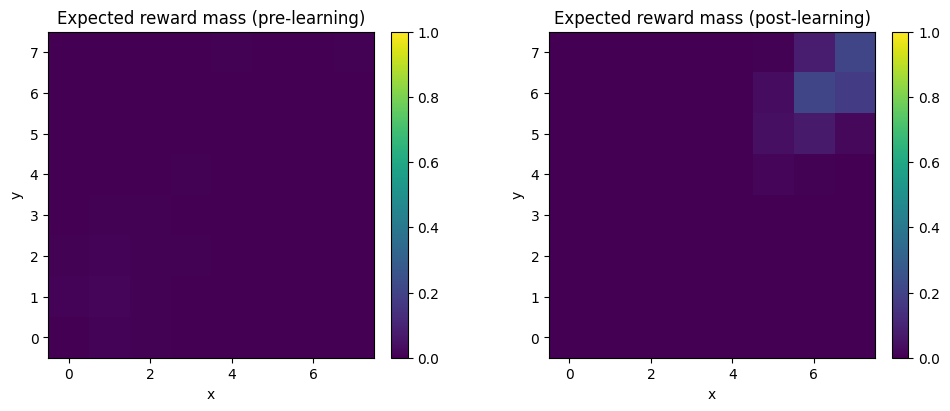

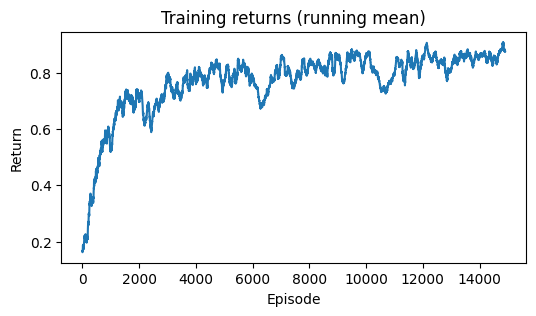

In [83]:
def make_bump_reward(width: int, height: int):
    def fn(x: int, y: int) -> float:
        # We should always have width > 1 and height > 1, but just in case
        nx = 0.0 if width <= 1 else x / (width - 1)
        ny = 0.0 if height <= 1 else y / (height - 1)
        return 0.5 * nx + 0.5 * ny

    return fn


# Configure env with a smooth reward surface over stop positions
W, H = 8, 8
reward_fn = make_bump_reward(W, H)

env = GridEnv(
    GridEnvConfig(width=W, height=H, stop_reward=0.0, stop_reward_fn=reward_fn)
)
policy = MLPPolicy(obs_dim=2, hidden_dim=32, num_actions=3)

# Pre-learning distribution
pre_mass, _ = estimate_reward_mass(env, policy, episodes=5000, seed=42)

# Train with REINFORCE
returns = train_reinforce(
    env, policy, episodes=15000, lr=1e-3, gamma=1.0, seed=42, max_steps=H + W
)

# Post-learning distribution
post_mass, _ = estimate_reward_mass(env, policy, episodes=5000, seed=42)

# Plot reward distributions before/after
fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
for ax, data, title in [
    (axes[0], pre_mass, "Expected reward mass (pre-learning)"),
    (axes[1], post_mass, "Expected reward mass (post-learning)"),
]:
    im = ax.imshow(data, origin="lower", cmap="viridis", vmin=0.0, vmax=1.0)
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.show()

# Plot returns curve
returns_running_mean = np.convolve(returns, np.ones(100) / 100, mode="valid")
plt.figure(figsize=(6, 3))
plt.plot(returns_running_mean)
plt.title("Training returns (running mean)")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.show()
